In [20]:
import numpy as np
import matplotlib.pyplot as plt
import numba as nb
import warnings
warnings.filterwarnings("ignore", category=FutureWarning)
warnings.filterwarnings("ignore", category=UserWarning)

# Load test samples
from tools import pickle_in
samples_g_1, samples_c_1, samples_w_1 = pickle_in("test_samples/samples_1.pickle")

from covariance import optimise_pr_cg, points_at_iteration, logX_covinv_chol, logX_mu, logX_covinv_rud, X_logL, logPr, logPr_params
from plotting import plot_fit_raw

#### Function to calculate mean and covariance for exact live point distributions

Matching matrices from Cholesky and direct methods, should be correct. Mean diverges from samples.logX() slightly, especially towards the end, likely due to samples.logX() using approximation.

In [2]:
iteration = 1000
nlive = 500
points = points_at_iteration(samples_g_1, iteration)
logL = points.logL
nk = np.array(points.nlive)

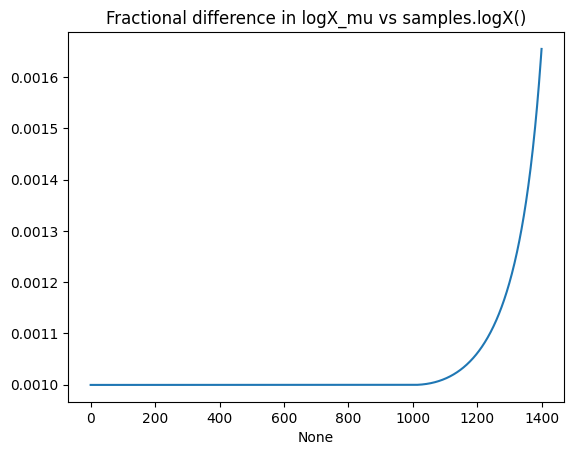

In [4]:
((logX_mu(np.array(points.nlive)) - points.logX())/points.logX())[:-100].plot()
plt.title("Fractional difference in logX_mu vs samples.logX()");

In [5]:
covinv_chol = logX_covinv_chol(nk)
covinv_rud = logX_covinv_rud(nk)
(covinv_chol - covinv_rud).max()

5.8119553614233896e-08

#### Fitting pure Gaussian

##### Only using dead points

In [9]:
# Check that the pure gaussian samples have a pure gaussian L(X) i.e. fit our model exactly by inferring d, sigma using LS
# As iteration number increases, the estimates for d, sigma become more accurate

from lm_full import levenberg_marquardt
from plotting import plot_fit_raw

iteration = 1000
points = points_at_iteration(samples_c_1, iteration)
points_dead = points.iloc[:iteration]
Xdead, logLdead = X_logL(points_dead)

<AxesSubplot: xlabel='None'>

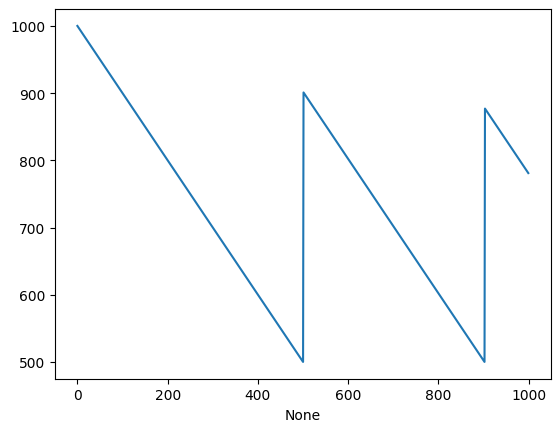

In [10]:
points_dead.nlive.plot()

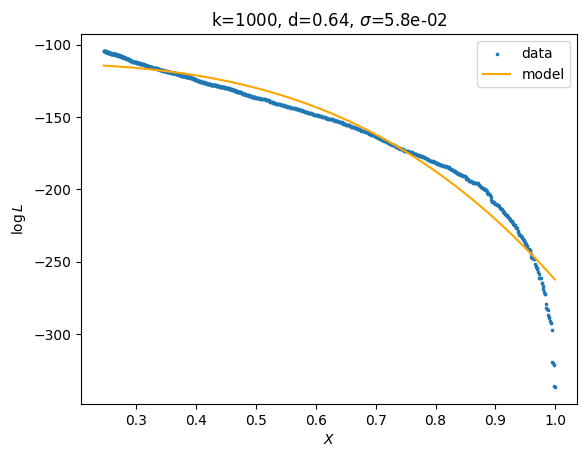

In [17]:
params = levenberg_marquardt(logLdead, Xdead, [-1, 10, 0.1]).x
plot_fit_raw(Xdead, logLdead, params)

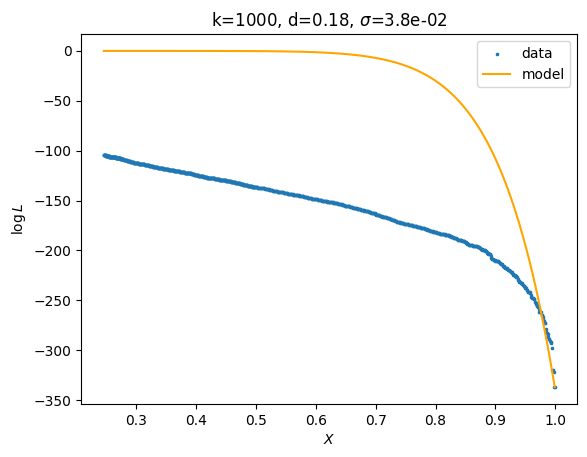

In [18]:
nk_dead = np.array(points_dead.nlive)
mean = logX_mu(nk_dead)
covinv = logX_covinv_chol(nk_dead)
params = optimise_pr_cg(logLdead, mean, covinv, [-0.1, 10, 0.1]).x
plot_fit_raw(Xdead, logLdead, params)

##### Now using both live and dead points

<AxesSubplot: xlabel='None'>

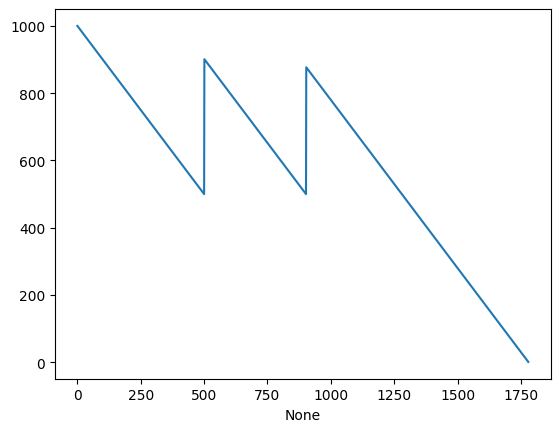

In [19]:
points.nlive.plot()

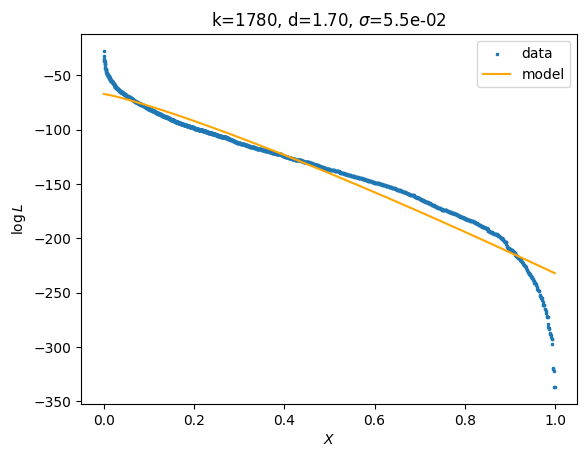

In [20]:
X, logL = X_logL(points)
params = levenberg_marquardt(logL, X, [-1, 10, 0.1]).x
plot_fit_raw(X, logL, params)

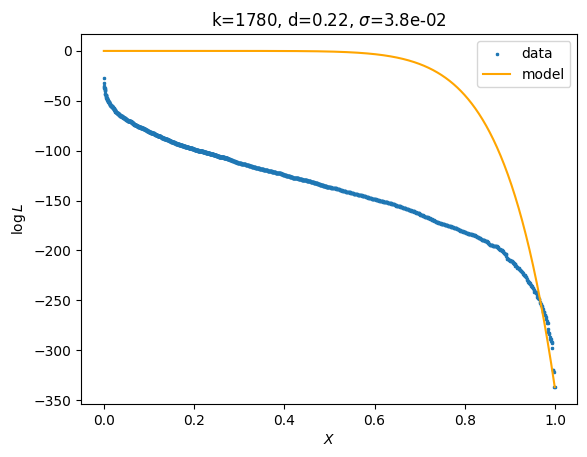

In [21]:
nk = np.array(points.nlive)
mean = logX_mu(nk)
covinv = logX_covinv_chol(nk)
params = optimise_pr_cg(logL, mean, covinv, [-0.1, 10, 0.1]).x
plot_fit_raw(X, logL, params)

#### Visualise distribution of points in X

Want an easy way to check whether the distribution of points in X. Do we want uniform in X or logX? Result is dead points are uniform in logX, live points decreasing

In [6]:
def plot_likelihood(points, ndead, **kwargs):
    """Plots logL against X for a set of samples"""
    ls = kwargs.get("ls", '-')
    ms = kwargs.get("ms", .5)
    axv = kwargs.get("avx", False)

    nk = np.array(points.nlive)
    X, logL = X_logL(points)
    plt.plot(X, logL, ls, ms=ms)
    if axv:
        plt.axvline(x=X[ndead], ls='--')
    plt.xlabel("$X$")
    plt.ylabel("$\log L$")


def X_distribution(points, bins=100):
    """Plots distribution of X in a set of samples"""
    X, logL = X_logL(points)
    fig, ax = plt.subplots(1, 2, figsize=(6,2), dpi=200)
    ax[0].hist(X, bins=bins, histtype="step")
    ax[0].set_xlabel("X")
    ax[1].hist(np.log(X), bins=bins, histtype="step")
    ax[1].set_xlabel("logX")

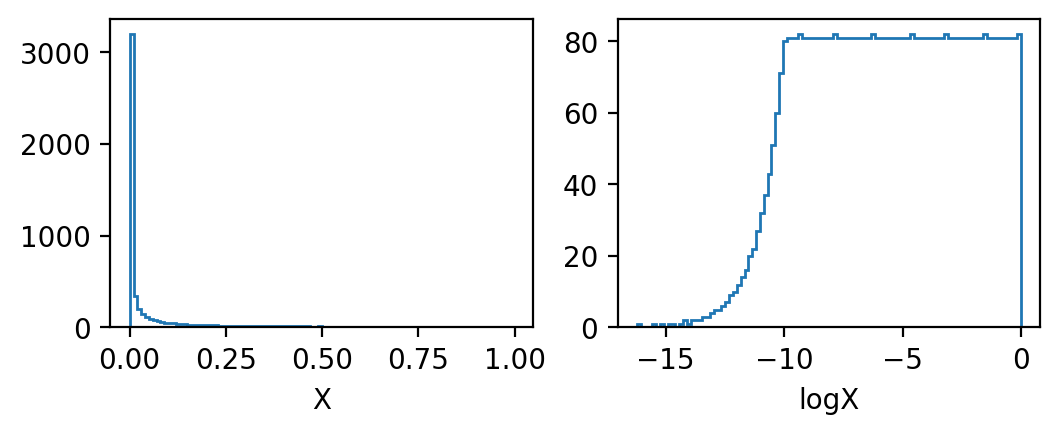

In [7]:
iteration = 5000
points = points_at_iteration(samples_g_1, iteration)
X_distribution(points)

In [ ]:
# Plot dead + live points at middle of run vs at end of the run
plt.figure(figsize=(12,5), dpi=150)
plot_likelihood(samples_g_1, len(samples_g_1)-1)
plot_likelihood(points, iteration, ls="x", ms=2, axv=True)

#### Contours

In [8]:
from covariance import brute
from plotting import contours

iteration = 1000
points = points_at_iteration(samples_g_1, iteration)
logL = np.array(points.logL)

nk = np.array(points.nlive)
mean = logX_mu(nk)
covinv = logX_covinv_chol(nk)
covinv_ls = np.diag(np.ones_like(mean))

ImportError: cannot import name 'brute' from 'covariance' (/home/zixiao/Documents/III/aeons/src/covariance.py)

In [12]:
grids_ls = brute(logL, mean, covinv_ls, 20)
contours(grids_ls)

interactive(children=(IntSlider(value=0, description='logLmax_index', max=19), Output()), _dom_classes=('widge…

In [13]:
grids_cg = brute(logL, mean, covinv_ls, 20)
contours(grids_cg)

interactive(children=(IntSlider(value=0, description='logLmax_index', max=19), Output()), _dom_classes=('widge…

In [ ]:
from lm_full import levenberg_marquardt
from covariance import optimise_pr_cg, points_at_iteration, logX_covinv_chol, logX_mu, X_logL, logX_model, logPr_params, grid_search
from plotting import plot_fit_raw, X_distribution

iteration = 1000
points = points_at_iteration(samples_g_1, iteration)
nk = np.array(points.nlive)
mean = logX_mu(nk)
X = np.exp(mean)
covinv = logX_covinv_chol(nk)
logL = np.array(points.logL)

#plt.plot(X, logL)
#X_distribution(points, iteration)

#### Likelihood sliders

In [ ]:
def likelihood_sliders(logL, mean, covinv):
    @interact(
        logLmax=widgets.FloatSlider(min=logL.max(), max=0.0, step=0.1), 
        d=widgets.FloatSlider(min=1.0, max=20.0, step=0.5),
        sigma=widgets.FloatSlider(min=0.08, max=0.12, step=0.001)
        )
    def logPr_sliders(logLmax, d, sigma):
        logX = logX_model(logL, logLmax, d, sigma)
        logPr = - (logX - mean).T @ np.diag(np.diagonal(covinv)) @ (logX - mean)
        X = np.exp(mean)
        plot_fit_raw(X, logL, [logLmax, d, sigma])
        plt.title(f"logPr={logPr:.2e}")

In [ ]:
covinv

array([[ 5.0e+05, -2.5e+05,  0.0e+00, ...,  0.0e+00,  0.0e+00,  0.0e+00],
       [-2.5e+05,  5.0e+05, -2.5e+05, ...,  0.0e+00,  0.0e+00,  0.0e+00],
       [ 0.0e+00, -2.5e+05,  5.0e+05, ...,  0.0e+00,  0.0e+00,  0.0e+00],
       ...,
       [ 0.0e+00,  0.0e+00,  0.0e+00, ...,  1.3e+01, -4.0e+00,  0.0e+00],
       [ 0.0e+00,  0.0e+00,  0.0e+00, ..., -4.0e+00,  5.0e+00, -1.0e+00],
       [ 0.0e+00,  0.0e+00,  0.0e+00, ...,  0.0e+00, -1.0e+00,  1.0e+00]])

In [ ]:
likelihood_sliders(logL, mean, covinv)

interactive(children=(FloatSlider(value=0.0, description='logLmax', max=0.0, min=-9.672423255965107), FloatSli…

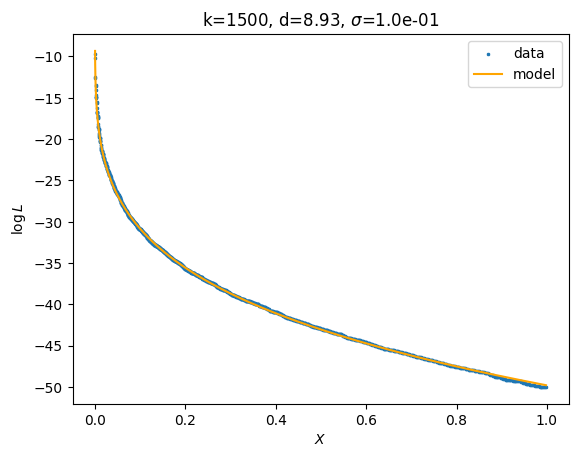

In [ ]:
from lm_partial import analytic_lm_params
params_ls = analytic_lm_params(logL, X, 10)
plot_fit_raw(X, logL, params_ls)

#### Brute force search to confirm global maxima

In [ ]:
def contours_likelihoods(grids, min_likelihood=-1000):
    """Plots contours for adjustable values of logLmax given a (N, N, N) array of likelihood evaluations at the specified parameters
    Input parameter grids = [logLmaxs, ds, sigmas, logPrs] where the logLmaxs etc are arrays of where the function was evalutated"""
    logLmaxs, ds, sigmas, logPrs = grids
    N = len(logLmaxs)

    @interact(logLmax_index=widgets.IntSlider(min=0, max=N-1, step=1))
    def dsigma_contour_likelihood(logLmax_index):
        dv, sigmav = np.meshgrid(ds, sigmas)
        fig, axs = plt.subplots(1,2, figsize=(6,3), dpi=120)
        
        # Plot contour
        contour_range = np.linspace(min_likelihood, logPrs[logLmax_index].max(), 20)
        axs[0].contourf(dv, sigmav, logPrs[logLmax_index].T, contour_range);
        max_logPr = logPrs[logLmax_index].max()
        (d_max_index, sigma_max_index) = np.unravel_index(logPrs[logLmax_index].argmax(), logPrs[logLmax_index].shape)
        dbest, sigmabest = ds[d_max_index], sigmas[sigma_max_index]
        axs[0].scatter(dbest, sigmabest, marker="x")
        
        # Plot likelihood of best d, sigma for fixed logLmax
        logX_best = logX_model(logL, logLmaxs[logLmax_index], dbest, sigmabest)
        axs[1].plot(X, logL, label="data")
        axs[1].plot(np.exp(logX_best), logL, label="model")
        fig.suptitle(f"logLmax={logLmaxs[logLmax_index]:.1f}, d={dbest:.2f}, $\sigma$={sigmabest:.3f}, logPrmax={max_logPr:.2f}")
        plt.tight_layout()
contours_likelihoods(grids_cg)

In [ ]:
def contours(grids, min_likelihood=-1000, levels=20, which_slider=0):
    logLmaxs, ds, sigmas, logPrs = grids
    params = [logLmaxs, ds, sigmas]
    slider_params = params[which_slider]
    params1, params2 = np.delete(params, which_slider)
    N = len(slider_params)
    
    @interact(slider_params_index=widgets.IntSlider(min=0, max=N-1, step=1))
    def plot_contour(slider_params_index):
        params1v, params2v = np.meshgrid(params1, params2)
        if which_slider == 0:
            relevant_logPrs = logPrs[slider_params_index]
        elif which_slider == 1:
            relevant_logPrs = logPrs[:, slider_params_index]
        elif which_slider == 2:
            relevant_logPrs = logPrs[:, :, slider_params_index]
        if relevant_logPrs.max() < min_likelihood:
            raise ValueError("Minimum likelihood too high")
        
        contour_range = np.linspace(min_likelihood, relevant_logPrs.max(), levels)
        plt.contourf(params1v, params2v, relevant_logPrs.T, contour_range);
        max_val = logPrs[slider_params_index].max()
        (params1_max_index, params2_max_index) = np.unravel_index(relevant_logPrs.argmax(), relevant_logPrs.shape)
        dbest, sigmabest = ds[params1_max_index], sigmas[params2_max_index]
        plt.scatter(dbest, sigmabest, marker="x")
        plt.xlabel("d")
        plt.ylabel("$\sigma$")
        plt.title(f"logLmax={logLmaxs[slider_params_index]:.1f}, d={dbest:.2f}, $\sigma$={sigmabest:.3f}, logPr={max_val:.2f}")

In [ ]:
Ls = np.linspace(-9, 1, 20)
ds = np.linspace(1, 20, 20)
ss = np.linspace(0.01, 0.12, 10)

In [ ]:
logPrs = grid_search(logL, mean, np.diag(np.ones_like(mean)), [Ls, ds, ss])

In [ ]:
contours([Ls, ds, ss, logPrs], min_likelihood=-20000, which_slider=0)

interactive(children=(IntSlider(value=0, description='slider_params_index', max=19), Output()), _dom_classes=(…

#### MCMC contours

In [317]:
iteration = 1300
points = points_at_iteration(samples_g_1, iteration)
nk = np.array(points.nlive)
mean = logX_mu(nk)
covinv = logX_covinv_chol(nk)
logL = np.array(points.logL)

In [311]:
def log_prior_full(theta):
    logLmax, d, sigma = theta
    if -9.0 < logLmax < 0.0 and 1.0 < d < 10.0 and 0.05 < sigma < 0.15:
        return 0.0
    return -np.inf


def log_prob_full(theta, logL, mean, covinv):
    logPr = logPr_params(logL, mean, covinv, theta)
    lp = log_prior_full(theta)
    if not np.isfinite(lp):
        return -np.inf
    return logPr_params(logL, mean, covinv, theta)


def log_prob_fixed_Lmax(theta, logLmax, logL, mean, covinv):
    d, sigma = theta
    theta_full = np.array([logLmax, d, sigma])
    lp = log_prior_full(theta_full)
    if not np.isfinite(lp):
        return -np.inf
    return logPr_params(logL, mean, covinv, theta_full)

In [313]:
import pandas as pd
import emcee

def mcmc_fixed_Lmax(logL, mean, covinv, logLmax, steps, nwalkers=32):
    ndim_fixed = 2
    d0 = np.random.uniform(1, 10, (nwalkers,))
    sigma0 = np.random.uniform(0.05, 0.15, (nwalkers,))
    p0_fixed = np.array([d0, sigma0]).T # set initial positions of the walkers
    sampler_fixed = emcee.EnsembleSampler(nwalkers, ndim_fixed, log_prob_fixed_Lmax, args=[logLmax, logL, mean, covinv])
    sampler_fixed.run_mcmc(p0_fixed, steps)
    samples = sampler_fixed.get_chain(flat=True)
    samples_df = pd.DataFrame(samples, columns=["d", "sigma"])
    samples_df["logL"] = sampler_fixed.get_log_prob(flat=True)
    return samples_df

In [330]:
mcmcsamples = mcmc_fixed_Lmax(logL, mean, covinv, -1.1, 20, nwalkers=32)

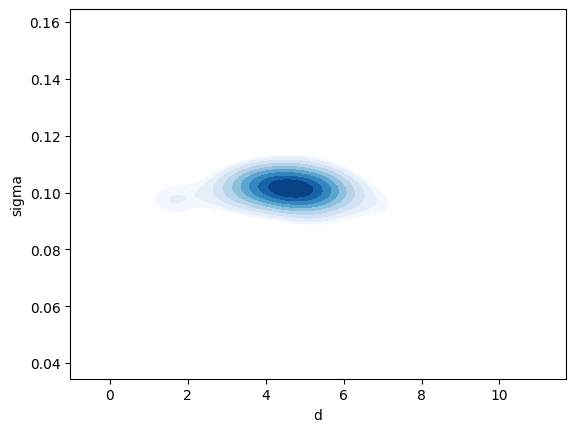

In [333]:
import seaborn as sns
ax = sns.kdeplot(x=mcmcsamples.d, y=mcmcsamples.sigma, fill=True, thresh=0.5, cmap="Blues");